<a href="https://www.kaggle.com/code/golammostofas/multi-agent-supervisor-langchain-langgraph?scriptVersionId=227340450" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Setup

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental
%pip install langgraph-supervisor langchain-openai


In [2]:
from kaggle_secrets import UserSecretsClient
import os
user_secrets = UserSecretsClient()
os.environ['ANTHROPIC_API_KEY'] = user_secrets.get_secret("ANTHROPIC_API_KEY")
os.environ['TAVILY_API_KEY'] = user_secrets.get_secret("TAVILY_API_KEY")
os.environ['OPENAI_API_KEY'] = user_secrets.get_secret("OPENAI_API_KEY")



In [3]:
from langchain_openai import ChatOpenAI
from langgraph_supervisor import create_supervisor

model = ChatOpenAI(model="gpt-4o")

# Create tools

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

# Create Agent Supervisor

In [5]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[(*options,)]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[(*members, "__end__")]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# Construct Graph

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

# Build the state graph
builder = StateGraph(State)
builder.add_edge(START, "supervisor")

# Add nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)


# Compile the graph
graph = builder.compile()


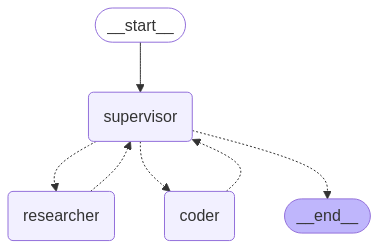

In [7]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")


((), {'supervisor': {'next': 'coder'}})
----
(('coder:7fc03793-b243-7fcf-d059-8d2aa856a8ca',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you calculate the square root of 42 using Python.", 'type': 'text'}, {'id': 'toolu_01DC5pfrdymctyiLPnWWGAEv', 'input': {'code': 'import math\nprint(math.sqrt(42))'}, 'name': 'python_repl_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01XmLX879agc3C9Woziqrjrh', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 435, 'output_tokens': 82}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-bfeb5b96-969c-43d3-8014-cb5ec248679c-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'toolu_01DC5pfrdymctyiLPnWWGAEv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 435, 'output_tokens': 82, 'total_tokens': 517, 'input_to

In [9]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:54daca47-dd51-9844-a156-d0a92275942a',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you search for the latest GDP data for New York and California. Let me look this up.", 'type': 'text'}, {'id': 'toolu_01AcofQGwTkw1S4EvnyWWSqU', 'input': {'query': 'latest GDP New York state 2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01HyAv8UtBp16mLqTBSrA6kT', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 442, 'output_tokens': 88}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-c537e20f-fdb4-4bf7-96af-d167041b150b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP New York state 2023'}, 'id': 'toolu_01AcofQGwTkw1S4EvnyWWSqU', 'type': 'tool_call'}], usage_metadata={'input_toke

# Create Agent Supervisor for Bangla and English query

In [10]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["bengali_query", "english_query"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor managing a conversation between the following workers: {members}. "
    "Based on the user's request, determine which worker should act next. Each worker will perform "
    "a task and respond with their results and status. If the user provides a query in Bengali, "
    "assign the task to the 'bengali_query' agent. If the query is in English, assign it to the 'english_query' agent. "
    "Only one agent should be used at a time. Once the task is completed, respond with 'FINISH'."
)  

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[(*options,)]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[(*members, END)]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = model.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
        

    return Command(goto=goto, update={"next": goto})

In [11]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


bengla_agent = create_react_agent(
    model, tools=[], prompt="You are a bengla query response asistant.", name='bengla_agent'
)


def bengla_node(state: State) -> Command[Literal["supervisor"]]:
    result = bengla_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="bengali_query")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
english_agent = create_react_agent(model, tools=[], prompt="You are a english query response asistant.", name='english_agent')


def english_node(state: State) -> Command[Literal["supervisor"]]:
    result = english_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="english_query")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("bengali_query", bengla_node)
builder.add_node("english_query", english_node)
graph = builder.compile()

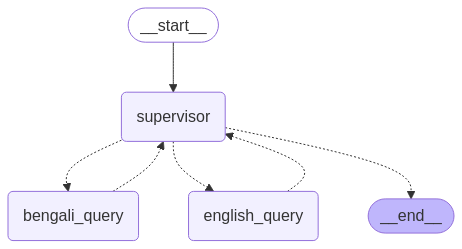

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
for s in graph.stream(
    {"messages": [("user", "What's the integration of x^2")]}, subgraphs=True, 
):
    print(s)
    print("----")


((), {'supervisor': {'next': 'english_query'}})
----
(('english_query:fb0824e0-42bf-15e9-1931-88aa2e1e5378',), {'agent': {'messages': [AIMessage(content='The integral of \\( x^2 \\) with respect to \\( x \\) is calculated by applying the power rule for integration. The power rule states that the integral of \\( x^n \\) is \\( \\frac{x^{n+1}}{n+1} + C \\), where \\( C \\) is the constant of integration and \\( n \\neq -1 \\).\n\nFor \\( x^2 \\), we have:\n\n\\[\n\\int x^2 \\, dx = \\frac{x^{2+1}}{2+1} + C = \\frac{x^3}{3} + C\n\\]\n\nSo, the integral of \\( x^2 \\) is \\( \\frac{x^3}{3} + C \\).', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 27, 'total_tokens': 181, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerp

In [14]:
for s in graph.stream(
    {"messages": [("user", "x^2 এর ইন্টেগ্রাশন কি?")]},
):
    if 'bengali_query' in s:
        print(s['bengali_query']['messages'][-1].content)
    print("----")


----
\( x^2 \) এর ইন্টেগ্রেশন হল:

\[
\int x^2 \, dx = \frac{x^3}{3} + C
\]

এখানে \( C \) একটি ইন্টেগ্রেশন কন্সট্যান্ট।
----
----


In [15]:
workflow = create_supervisor(
    [bengla_agent, english_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a bangla query expert and a english query expert. "
        "For user bengla query, use bengla_agent. "
        "For user english query, use english_agent."
    )
)
# Compile and run
app = workflow.compile()


In [16]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "x^2 এর ইন্টেগ্রাশন কি?"
        }
    ]
})
result

{'messages': [HumanMessage(content='x^2 এর ইন্টেগ্রাশন কি?', additional_kwargs={}, response_metadata={}, id='1d61fa09-0f92-437e-bd5f-f7781181f5c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1G4QXjTZPoXoyYsUgbGYRBXt', 'function': {'arguments': '{}', 'name': 'transfer_to_bengla_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 107, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-f6a5e5ef-3a5b-4eb1-93bb-19334942a96f-0', tool_calls=[{'name': 'transfer_to_bengla_agent', 'args': {}, 'id': 'call_1G4QXjTZPoXoyYsUgbGYRBXt', 'type': 'tool_call'}], usage_metadata={'inp

In [17]:


result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content":"What's the integration of x^2"
        }
    ]
})
result

{'messages': [HumanMessage(content="What's the integration of x^2", additional_kwargs={}, response_metadata={}, id='7c5466ef-2323-4947-87f6-b07e17948811'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3DNwQ6zf1UAuTgA2lGqYNemH', 'function': {'arguments': '{}', 'name': 'transfer_to_english_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 102, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_0d4eb8a50b', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-546dc8ad-d636-4713-a5b1-bb5e286a9e19-0', tool_calls=[{'name': 'transfer_to_english_agent', 'args': {}, 'id': 'call_3DNwQ6zf1UAuTgA2lGqYNemH', 'type': 'tool_call'}], usage_metad

In [18]:
from langchain.schema import AIMessage

for s in result['messages']:
    if isinstance(s, AIMessage) and (s.name == 'english_agent' or s.name == 'bengla_agent') and len(s.response_metadata) > 1:
        print(s.content, '\n----')

The integration of \( x^2 \) with respect to \( x \) is given by the formula for integrating polynomial expressions. The integral of \( x^n \) is \(\frac{x^{n+1}}{n+1} + C\), where \( n \neq -1 \) and \( C \) is the constant of integration. 

For \( x^2 \), \( n = 2 \), so:

\[
\int x^2 \, dx = \frac{x^{2+1}}{2+1} + C = \frac{x^3}{3} + C
\]

where \( C \) is the constant of integration. 
----
